Importamos las librerias necesarias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import utils
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#### **Exploratory Data Analisys**

In [3]:
data = pd.read_csv('../data/retail_sales_dataset.csv')
data.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


Eliminamos las columnas Transaction ID y Customer ID porque no aportan nada al analisis

In [4]:
data = data.drop(columns=['Transaction ID', 'Customer ID'])


Verificamos si hay duplicados, en caso de haber, lo eliminamos.

In [5]:
# Identificar duplicados
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados antes de eliminarlos: {num_duplicados}")

# Eliminar duplicados y actualizar el DataFrame
data = data.drop_duplicates()

# Identificar duplicados nuevamente
duplicados = data.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados después de eliminarlos: {num_duplicados}")

Número de registros duplicados antes de eliminarlos: 0
Número de registros duplicados después de eliminarlos: 0


Calculamos los NA en todo el Dataset

In [6]:
utils.calculate_na_statistics(data)

,datos sin NAs en q,Na en q,Na en %
Date,1000,0,0.0
Gender,1000,0,0.0
Age,1000,0,0.0
Product Category,1000,0,0.0
Quantity,1000,0,0.0
Price per Unit,1000,0,0.0
Total Amount,1000,0,0.0


Convertimos las las columnas a sus respectivos Dtypes

In [7]:
data_dict = {
    'Date': 'datetime64',
    'Gender': 'category',
    'Age': 'int64',
    'Product Category': 'category',
    'Price per Unit': 'int64',
    'Total Amount': 'int64',    
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data[column] = data[column].astype(dtype, errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Date              1000 non-null   object  
 1   Gender            1000 non-null   category
 2   Age               1000 non-null   int64   
 3   Product Category  1000 non-null   category
 4   Quantity          1000 non-null   int64   
 5   Price per Unit    1000 non-null   int64   
 6   Total Amount      1000 non-null   int64   
dtypes: category(2), int64(4), object(1)
memory usage: 41.4+ KB


Como Date tiene problemas, lo haremos manual

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1000 non-null   datetime64[ns]
 1   Gender            1000 non-null   category      
 2   Age               1000 non-null   int64         
 3   Product Category  1000 non-null   category      
 4   Quantity          1000 non-null   int64         
 5   Price per Unit    1000 non-null   int64         
 6   Total Amount      1000 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 41.4 KB


Verificamos las distribuciones de las columnas numericas

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Price per Unit'}>],
       [<Axes: title={'center': 'Total Amount'}>, <Axes: >]], dtype=object)

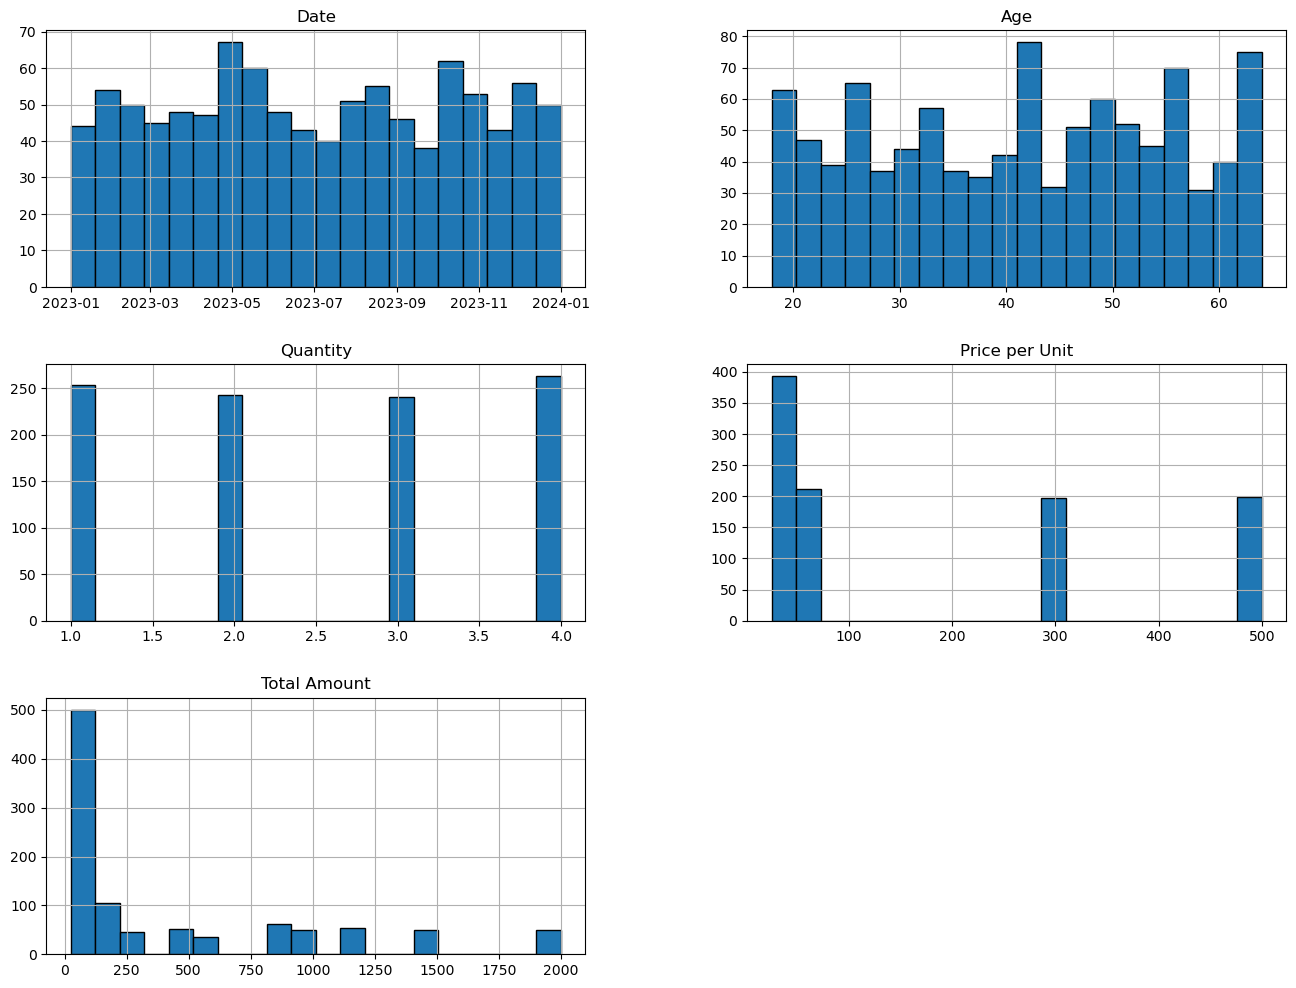

In [9]:
data.dropna().hist(figsize=(16, 12), bins='rice', edgecolor='black')

Seleccionamos las columnas numericas en una variable para poder trabajar mejor

In [10]:
numeric_cols = data.select_dtypes(include=[np.number])

Sacamos las estadisticas descriptivas

In [11]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in numeric_cols:
    datos_columna = data[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
Age,1000.0,41.39,42.0,13.68,18.0,64.0,29.0,53.0
Quantity,1000.0,2.51,3.0,1.13,1.0,4.0,1.0,4.0
Price per Unit,1000.0,179.89,50.0,189.68,25.0,500.0,30.0,300.0
Total Amount,1000.0,456.00,135.0,560.00,25.0,2000.0,60.0,900.0


Calculamos los Outliers en las columnas numericas

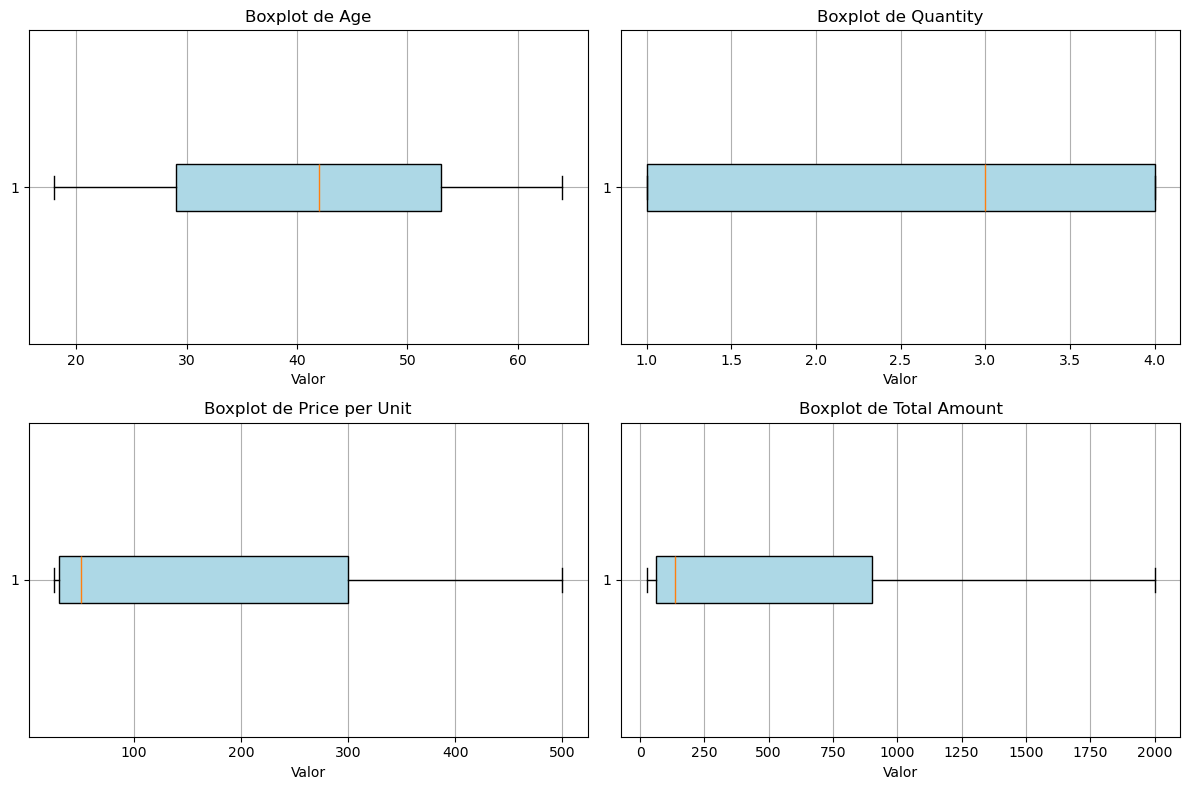

In [12]:
# Crear gráficos de boxplot separados para cada característica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Graficar cada variable en un boxplot separado
for i, col in enumerate(numeric_cols.columns):
    axes[i].boxplot(numeric_cols[col], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('Valor')
    axes[i].grid()

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [13]:

# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numeric_cols:
    outliers = utils.detect_outliers_iqr(numeric_cols[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': numeric_cols[column][~outliers].min(),
        'Upper Bound': numeric_cols[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
Age,0.0,0.0,18.0,64.0
Quantity,0.0,0.0,1.0,4.0
Price per Unit,0.0,0.0,25.0,500.0
Total Amount,0.0,0.0,25.0,2000.0


Creamos una matriz de correlacion de las variables numericas

In [14]:
# Calcular la matriz de correlación utilizando Pearson
matriz_correlacion = numeric_cols.dropna().corr(method='pearson')
# Mostrar la matriz de correlación
print("\nMatriz de Correlación (Pearson):")
matriz_correlacion


Matriz de Correlación (Pearson):


,Age,Quantity,Price per Unit,Total Amount
Age,1.000000,-0.023737,-0.038423,-0.060568
Quantity,-0.023737,1.000000,0.017501,0.373707
Price per Unit,-0.038423,0.017501,1.000000,0.851925
Total Amount,-0.060568,0.373707,0.851925,1.000000


Graficamos la correlacion

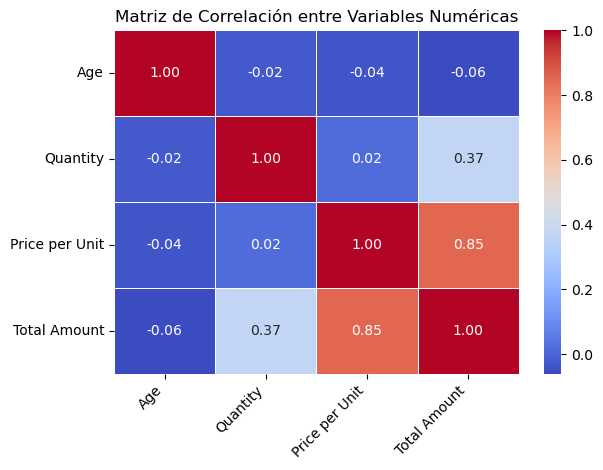

In [15]:
# Configurar el tamaño de la figura
plt.figure()
# Crear el heatmap utilizando seaborn
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# Añadir títulos y etiquetas
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Graficamos en un Subplots algunas variables claves

C:\Users\guill\AppData\Local\Temp\ipykernel_15008\3956470549.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_arrow = df_resampled['Quantity'][5]  # Cantidad correspondiente al sexto mes
C:\Users\guill\AppData\Local\Temp\ipykernel_15008\3956470549.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_text = df_resampled['Quantity'][5] + 100  # Ajusta el +100 según necesites


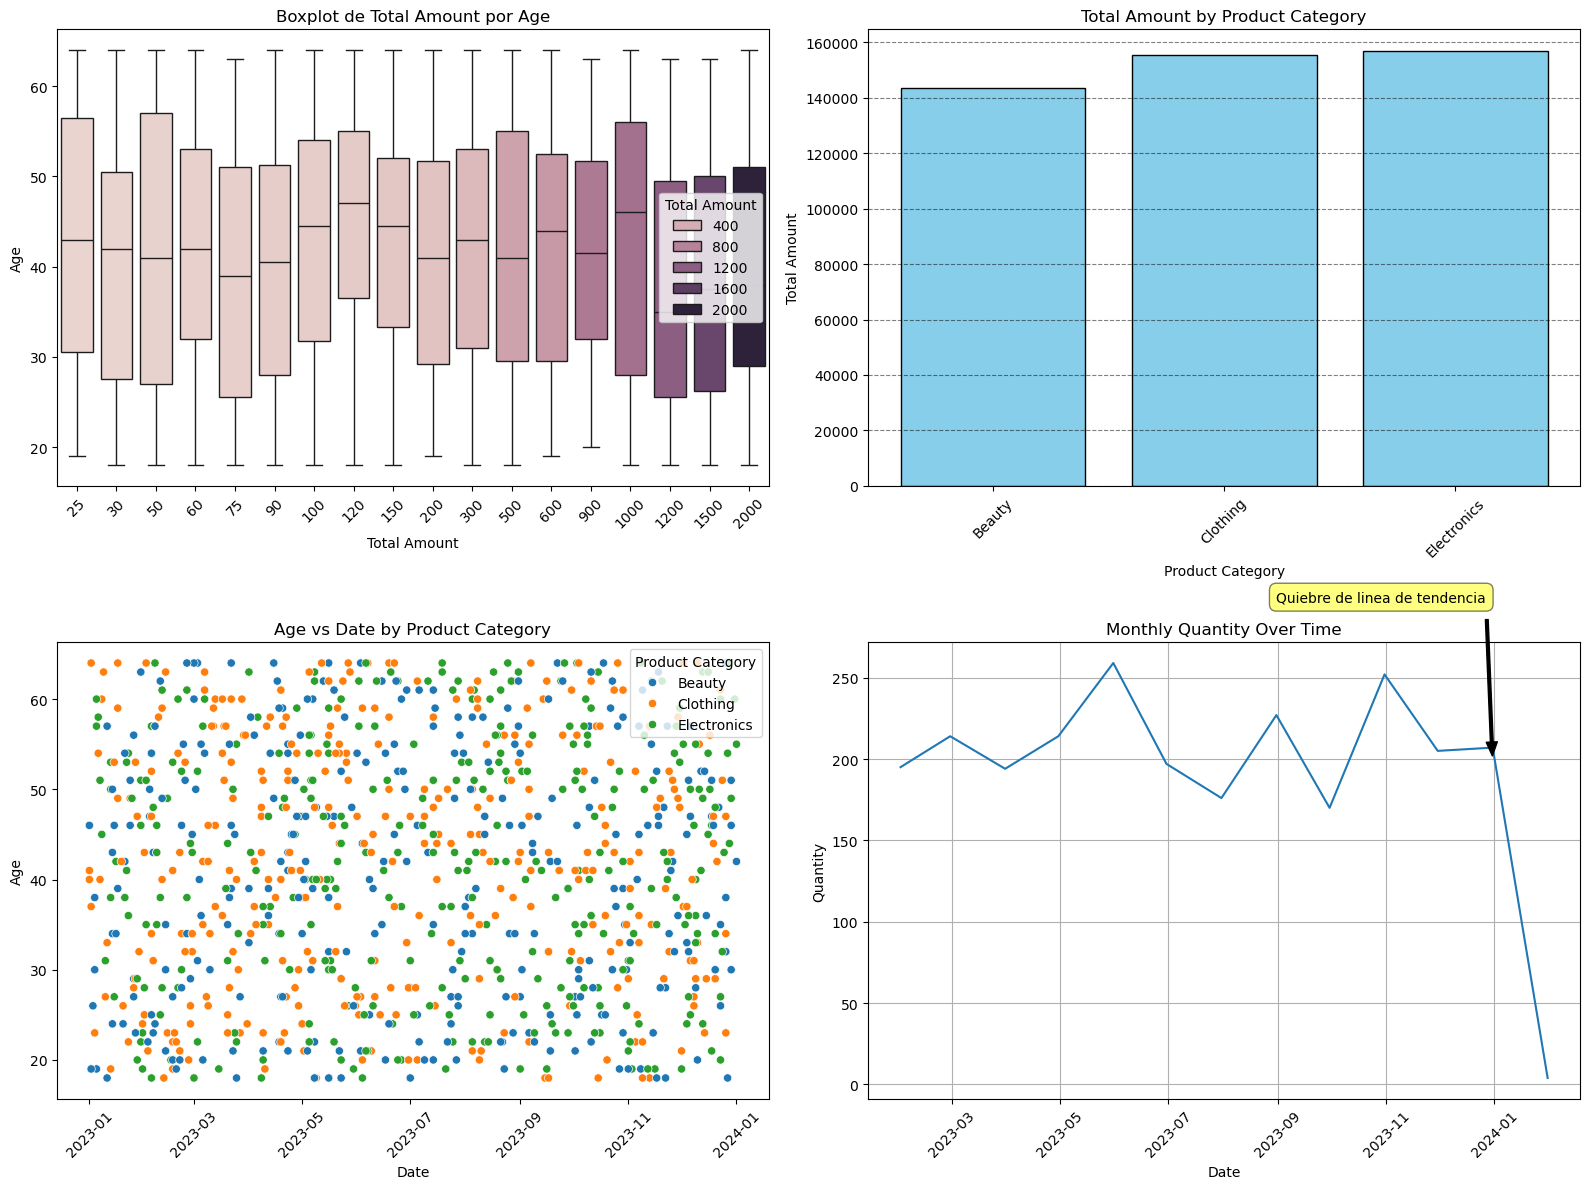

In [16]:
# Crear la figura y los ejes para los subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 filas, 2 columnas

# Gráfico 1: Boxplot de Total Amount por Age
df_box_numerics = data[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].dropna()
sns.boxplot(x='Total Amount', y='Age', data=df_box_numerics, hue='Total Amount', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot de Total Amount por Age', fontsize=12)
axes[0, 0].set_xlabel('Total Amount', fontsize=10)
axes[0, 0].set_ylabel('Age', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Bar plot de Total Amount por Product Category
grouped3 = data.groupby('Product Category', observed=True)['Total Amount'].sum().reset_index()
axes[0, 1].bar(grouped3['Product Category'], grouped3['Total Amount'], color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Product Category')
axes[0, 1].set_ylabel('Total Amount')
axes[0, 1].set_title('Total Amount by Product Category')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.5, color = 'black')

# Gráfico 3: Scatter plot
sns.scatterplot(data=data, x='Date', y='Age', hue='Product Category', ax=axes[1, 0])
axes[1, 0].set_title('Age vs Date by Product Category')
axes[1, 0].tick_params(axis='x', rotation=45)

# Gráfico 4: Line plot
df_temp = data.copy()
df_temp.set_index('Date', inplace=True)

# Select only numeric columns for summing
numeric_cols = df_temp.select_dtypes(include=['int64', 'float64']).columns
df_resampled = df_temp[numeric_cols].resample('ME').sum()

# Plot the line graph using only numeric columns
sns.lineplot(data=df_resampled, x=df_resampled.index, y='Quantity', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Quantity Over Time')
axes[1, 1].set_ylabel('Quantity')
axes[1, 1].tick_params(axis='x', rotation=45)

# Agregar flecha y anotación
x_arrow = df_resampled.index[11]  # Ejemplo: punto en el sexto mes
y_arrow = df_resampled['Quantity'][5]  # Cantidad correspondiente al sexto mes
x_text = df_resampled.index[7]  # Posición del texto
y_text = df_resampled['Quantity'][5] + 100  # Ajusta el +100 según necesites

axes[1, 1].annotate(
    'Quiebre de linea de tendencia',  # Texto que quieres mostrar
    xy=(x_arrow, y_arrow),  # Punto donde termina la flecha
    xytext=(x_text, y_text),  # Punto donde se ubica el texto
    arrowprops=dict(
        facecolor='black',
        shrink=0.05,
        width=2,
        headwidth=8,
        headlength=10
    ),
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
)
# Ajustar el espaciado entre los gráficos
plt.tight_layout()
plt.grid()
plt.show()

Modeling

Seleccionamos la variable target y sus predictoras, separamos en train y test, y creamos el column transformer

In [ ]:
# Feature Engineering for Date
def extract_date_features(data):
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    return data.drop('Date', axis=1)

# Prepare the data
X = extract_date_features(data.drop('Total Amount', axis=1))
y = data['Total Amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = ['Age', 'Quantity', 'Price per Unit', 'Year', 'Month', 'Day', 'DayOfWeek']
categorical_features = ['Gender', 'Product Category']

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Creamos el Pipeline

In [18]:
# Create pipelines
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'KNN Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
}

Ver metricas de los modelos

In [19]:

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'R2': r2}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score 454.062500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Comparar Resultados

In [20]:
# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Sort by R2 score in descending order
results_df_sorted = results_df.sort_values(by='R2', ascending=False)

print(results_df_sorted)

                            MSE         MAE        R2
Decision Tree          0.000000    0.000000  1.000000
Random Forest          0.000000    0.000000  1.000000
XGBoost                0.000346    0.015037  1.000000
LightGBM               0.000207    0.011900  1.000000
KNN Regression     25158.375000  100.415000  0.914056
Linear Regression  43059.934235  175.561656  0.852902


Generar Reporte .TXT

In [25]:
# Method 1: Simple text export with basic formatting
with open('../reports/model_performance_report.txt', 'w') as f:
    for name, metrics in results.items():
        f.write(f"{name} Results:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value}\n")
        f.write("\n")

# Method 2: Using pandas to export nicely formatted DataFrame
results_df_sorted.to_csv('../reports/model_performance_report.txt', sep='\t')

# Method 3: More detailed formatted export
with open('../reports/model_performance_detailed_report.txt', 'w') as f:
    f.write("Machine Learning Model Performance Comparison\n")
    f.write("=" * 50 + "\n\n")
    
    for name, metrics in results.items():
        f.write(f"Model: {name}\n")
        f.write("-" * 20 + "\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        f.write("\n")
    
    # Optional: Add timestamp or additional metadata
    import datetime
    f.write(f"\nReport generated: {datetime.datetime.now()}")